In [1]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr, rankdata
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import os
import shutil
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




In [3]:
cwd = os.getcwd()

df_main = pd.read_csv(f'{cwd}\\data_primary\\final_2500_mRNA_gene_dataset.csv')
df_main = df_main.drop('Unnamed: 0',axis=1)

df_main

,0610005C13Rik,0610007C21Rik,0610007P14Rik,0610009B22Rik,0610009D07Rik,0610010F05Rik,0610011F06Rik,0610012G03Rik,0610038L08Rik,0610039K10Rik,...,Znhit1,Znrf2,Zranb3,Zrsr2,Zscan2,Zscan20,Zswim7,Zxdb,Zyx,l7Rn6
0,0,0,0,0,0,0,0,75,0,0,...,0,0,0,0,0,0,0,0,277,0
1,0,0,0,0,33,0,0,0,0,0,...,0,0,0,0,0,0,0,0,202,0
2,0,0,0,124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,26,0,0,19,0,0,0,0,3,0
4,0,2,0,0,0,0,0,1,0,0,...,0,0,0,14,0,0,43,0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,310,768,102,129,82,0,505,0,0,0,...,54,1,0,0,0,0,9,0,0,74
977,392,527,98,263,57,0,226,139,0,0,...,0,41,0,0,0,0,0,0,0,0
978,220,129,31,30,23,0,334,64,0,0,...,45,1,0,0,0,0,16,0,0,16
979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = df_main.iloc[:,:].to_numpy()
# df = np.transpose(df)

df.shape

(981, 2500)

In [7]:
sc = StandardScaler()
 
# df = sc.fit_transform(df)

In [6]:
total_sample = df.shape[0]
total_feature = df.shape[1]

In [7]:
total_feature

2500

Functions

In [8]:
def gen_feat_dist_ranking(data):
    num = data.shape[1]
    corr = np.corrcoef(np.transpose(data))
    corr = 1 - corr
    corr = np.around(a=corr, decimals=10)
    
    tril_id = np.tril_indices(num)
    rank = rankdata(corr[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)
    
    return ranking, corr


In [9]:
def gen_matx_dist_ranking(num_r, num_c):

    # generate the coordinates of elements in a matrix
    for r in range(num_r):
        if r == 0:
            coordinate = np.transpose(np.vstack((np.zeros(num_c), range(num_c))))
        else:
            coordinate = np.vstack((coordinate, np.transpose(np.vstack((np.ones(num_c) * r, range(num_c))))))

    # calculate the closeness of the elements
    num = num_r * num_c
    cord_dist = np.zeros((num, num))

    for i in range(num):
        cord_dist[i, :] = np.sqrt(np.square(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) + np.square(coordinate[i, 1] * np.ones(num) - coordinate[:, 1]))


    # generate the ranking based on distance
    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(cord_dist[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    coordinate = np.int64(coordinate)
    return (coordinate[:, 0], coordinate[:, 1]), ranking

Implementation

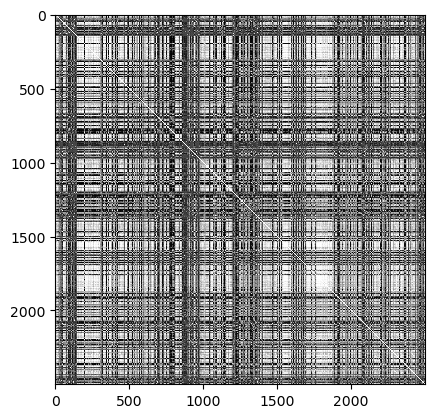

In [10]:
ranking_feature, corr = gen_feat_dist_ranking(df)
plt.imshow(np.max(ranking_feature) - ranking_feature, cmap='gray', interpolation='nearest')
plt.show()

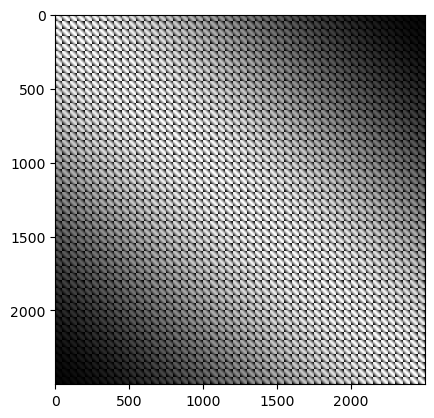

In [11]:
coordinate, ranking_image = gen_matx_dist_ranking(50,50)
# plt.imshow(ranking_image, cmap='gray')
plt.imshow(np.max(ranking_image) - ranking_image, cmap='gray', interpolation='nearest')
plt.show()

(15515, 15515)

In [20]:
df.shape[1]

15515

array([  0,   0,   1, ..., 979, 980, 981])